In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant

import matplotlib.pyplot as plt
import seaborn as sns

## Load data and build test/train split

In [2]:
data = pd.read_csv("./data/RRCA_baseflow.csv")

In [3]:
def test_train_split():
    data = data.sample(frac=1)
    split = int(0.8 * len(data))

    train = data.iloc[:split, :]
    test = data.iloc[split:, :]

    train.to_csv("./data/train.csv", index=None)
    test.to_csv("./data/test.csv", index=None)

# test_train_split()

In [15]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

split = int(0.8 * len(train))
train = train.sample(frac=1)

validation = train.iloc[split:, :]
validation_y = validation[["Observed"]]
validation_x = validation.drop(["Observed"], axis=1)

train = train.iloc[:split, :]
train_y = train[["Observed"]]
train_x = train.drop(["Observed"], axis=1)

## Explore data

In [12]:
print(f"Columns: {', '.join(data.columns.values)}")
print()

for header in data.columns:
    print(header)
    print(f"std: {data[[header]].values.flatten().std()}")
    print(f"avg: {data[[header]].values.flatten().mean()}")
    print(f"min: {data[[header]].values.flatten().min()}")
    print(f"max: {data[[header]].values.flatten().max()}")
    print()

Columns: Date, Segment_id, x, y, Evapotranspiration, Precipitation, Irrigation_pumping, Observed

Date
std: 6287.137751579983
avg: 719206.1753575781
min: 708479
max: 730729

Segment_id
std: 52.78791190766203
avg: 126.58989160413059
min: 40
max: 256

x
std: 292489.75358944904
avg: 1169435.2568789686
min: 721870
max: 1941550

y
std: 83307.80760590668
avg: 14570660.457956513
min: 14387040
max: 14767200

Evapotranspiration
std: 3.167133287231281
avg: 2.6874908601116028
min: 0.0
max: 12.1

Precipitation
std: 10.512571361268662
avg: 14.915468539542044
min: 0.0
max: 40.38

Irrigation_pumping
std: 0.27371714995088736
avg: -0.090712565133731
min: -3.1647
max: 0.0

Observed
std: 56.273487440683574
avg: 23.986753837712268
min: -22.0
max: 747.80328



## SKLearn Linear Regression

In [6]:
model = LinearRegression(fit_intercept=True, n_jobs=6)
model.fit(train_x, train_y)

prediction_y = model.predict(validation_x).flatten()
actual_y = validation_y.to_numpy().flatten()

mean_squared_error = 0.
mean_log_error = 0.
for index in range(len(prediction_y)):
    mean_squared_error += (prediction_y[index] - actual_y[index]) ** 2
    mean_log_error += np.log(np.abs(prediction_y[index] - actual_y[index]))
mean_squared_error /= len(prediction_y)
mean_log_error /= len(prediction_y)

r_squared = model.score(validation_x, validation_y)

print(f"MSE: {mean_squared_error:10.4f}")
print(f"MLE: {mean_log_error:10.4f}")
print(f"R^2: {r_squared:10.4f}")

MSE:  2306.7912
MLE:     2.7808
R^2:     0.2401


## Statsmodels Linear Regression

In [7]:
train_x2 = add_constant(train_x)
model = OLS(train_y, train_x2)
results = model.fit()
results.summary()

b:\applications\python3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     444.3
Date:                Tue, 10 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:45:05   Log-Likelihood:                -53136.
No. Observations:                9977   AIC:                         1.063e+05
Df Residuals:                    9969   BIC:                         1.063e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1664.9238    113.633     14.652      0.000    1442.181    1887.667
Date                  -0.0016   8.32e-05    -19.740      0.000      -0.002      -0.001
Segment_id             0.3518      0.010     35.586      0.000       0.332       0.371
x                   6.785e-06    1.8e-06      3.760      0.000    3.25e-06    1.03e-05
y                  -3.672e-05   6.73e-06     -5.460      0.000   -4.99e-05   -2.35e-05
Evapotranspiration    -0.3917      0.203     -1.928      0.054      -0.790       0.007
Precipitation          1.6947      0.057     29.969      0.000       1.584       1.806
Irrigation_pumping     6.0635      2.158      2.809      0.005       1.833      10.294
==============================================================================
Omnibus:                    11394.663   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1244426.587
Skew:                           5.956   Prob(JB):                         0.00
Kurtosis:                      56.401   Cond. No.                     3.34e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Statsmodels Linear Regression - Differing zones

In [102]:
train = pd.read_csv("./data/train.csv")
train = train.sample(frac=1)

segments = {}
def ln_reg(data):
    y = data[["Observed"]]
    x = data.drop(["Observed", "Segment_id", "x", "y"], axis=1)

    x2 = add_constant(x)
    model = OLS(y, x2)
    results = model.fit()
    print(f"Area: {'':15s} {int(data.iloc[0][['Segment_id']].values)}")
    print(f"R^2:  {'':15s} {results.rsquared:.7f}")
    print(results.pvalues)
    print()
    global segments
    segments[int(data.iloc[0][['Segment_id']].values)] = results

train.groupby("Segment_id").apply(ln_reg)

Area:                 40
R^2:                  0.4070359
const                 1.085925e-06
Date                  6.655312e-05
Evapotranspiration    6.987567e-02
Precipitation         6.458253e-02
Irrigation_pumping    4.140237e-11
dtype: float64

Area:                 51
R^2:                  0.0331012
const                 0.000304
Date                  0.000259
Evapotranspiration         NaN
Precipitation              NaN
Irrigation_pumping         NaN
dtype: float64

Area:                 53
R^2:                  0.0857821
const                 0.876543
Date                  0.902772
Evapotranspiration    0.000125
Precipitation         0.487609
Irrigation_pumping    0.110979
dtype: float64

Area:                 55
R^2:                  0.2100320
const                 9.922176e-10
Date                  6.698476e-10
Evapotranspiration    3.244546e-04
Precipitation         1.168079e-03
Irrigation_pumping    2.360019e-01
dtype: float64

Area:                 56
R^2:                  0

""


## Evaluate final model

In [103]:
test = pd.read_csv("./data/test.csv")

def ln_reg_eval(data):
    y = data[["Observed"]]
    x = data.drop(["Observed", "Segment_id", "x", "y"], axis=1)
    x2 = add_constant(x)
    actual_y = y.to_numpy().flatten()
    
    global segments
    model = segments[int(data.iloc[0][['Segment_id']].values)]
    
    try:
        prediction_y = model.predict(x2)
        prediction_y = prediction_y.to_numpy().flatten()
        
        mean_squared_error = 0.
        mean_log_error = 0.
        for index in range(len(prediction_y)):
            mean_squared_error += (prediction_y[index] - actual_y[index]) ** 2
            mean_log_error += np.log(np.abs(prediction_y[index] - actual_y[index]))
        mean_squared_error /= len(prediction_y)
        mean_log_error /= len(prediction_y)
        
        print(f"Area: {int(data.iloc[0][['Segment_id']].values)}")
        print(f"MSE: {mean_squared_error:10.4f}")
        print(f"MLE: {mean_log_error:10.4f}")
        print()
        
        segments[int(data.iloc[0][['Segment_id']].values)] = mean_squared_error
        
    except:
        pass
#     print(f"Area: {'':15s} {int(data.iloc[0][['Segment_id']].values)}")
#     print(f"R^2:  {'':15s} {results.rsquared:.7f}")
#     print(results.pvalues)
#     print()

test.groupby("Segment_id").apply(ln_reg_eval)
del segments[123]

Area: 40
MSE:     1.8452
MLE:    -0.3567

Area: 51
MSE:     0.0776
MLE:    -2.2778

Area: 53
MSE:  2964.4570
MLE:     3.6565

Area: 55
MSE:     0.7241
MLE:    -0.7196

Area: 56
MSE:     2.1085
MLE:    -0.3418

Area: 59
MSE:     1.7340
MLE:    -0.4358

Area: 60
MSE:     8.8649
MLE:     0.3224

Area: 62
MSE:     3.1680
MLE:    -0.1888

Area: 63
MSE:     0.0423
MLE:    -2.0683

Area: 64
MSE:     1.4666
MLE:    -0.4148

Area: 65
MSE:     2.7202
MLE:    -0.2424

Area: 96
MSE:    38.8351
MLE:     1.1083

Area: 97
MSE:    23.1007
MLE:     1.0564

Area: 98
MSE:     0.1441
MLE:    -1.5930

Area: 118
MSE:     0.0190
MLE:    -2.6179

Area: 130
MSE:    42.4782
MLE:     1.2670

Area: 135
MSE:     1.1536
MLE:    -0.5628

Area: 136
MSE:     7.3485
MLE:     0.3194

Area: 138
MSE:     5.1821
MLE:    -0.0260

Area: 144
MSE:    21.6947
MLE:     1.0493

Area: 145
MSE:     4.6190
MLE:     0.1150

Area: 146
MSE:     6.0791
MLE:     0.3752

Area: 147
MSE:    86.6995
MLE:     1.5150

Area: 148
MSE:     5.0798

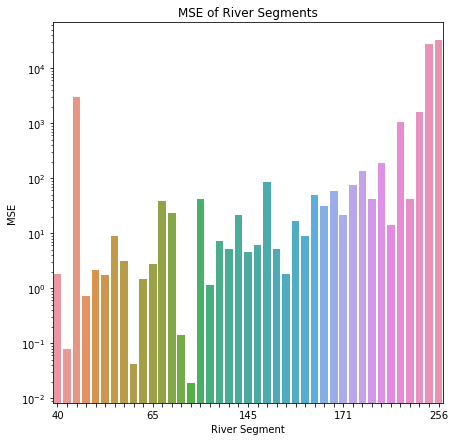

In [127]:
lists = sorted(segments.items())
x, y = zip(*lists)
x = list(x)
y = list(y)

f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")

plot_ = sns.barplot(x, y, ax=ax)
plt.title("MSE of River Segments")
plt.xlabel("River Segment")
plt.ylabel("MSE")

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.savefig("MSE_Segments.png")
plt.show()